# US State Obesity Analysis

---
Gianangelo Dichio, Math & Data \
Advisor: PhD Hadi Safari Katesari

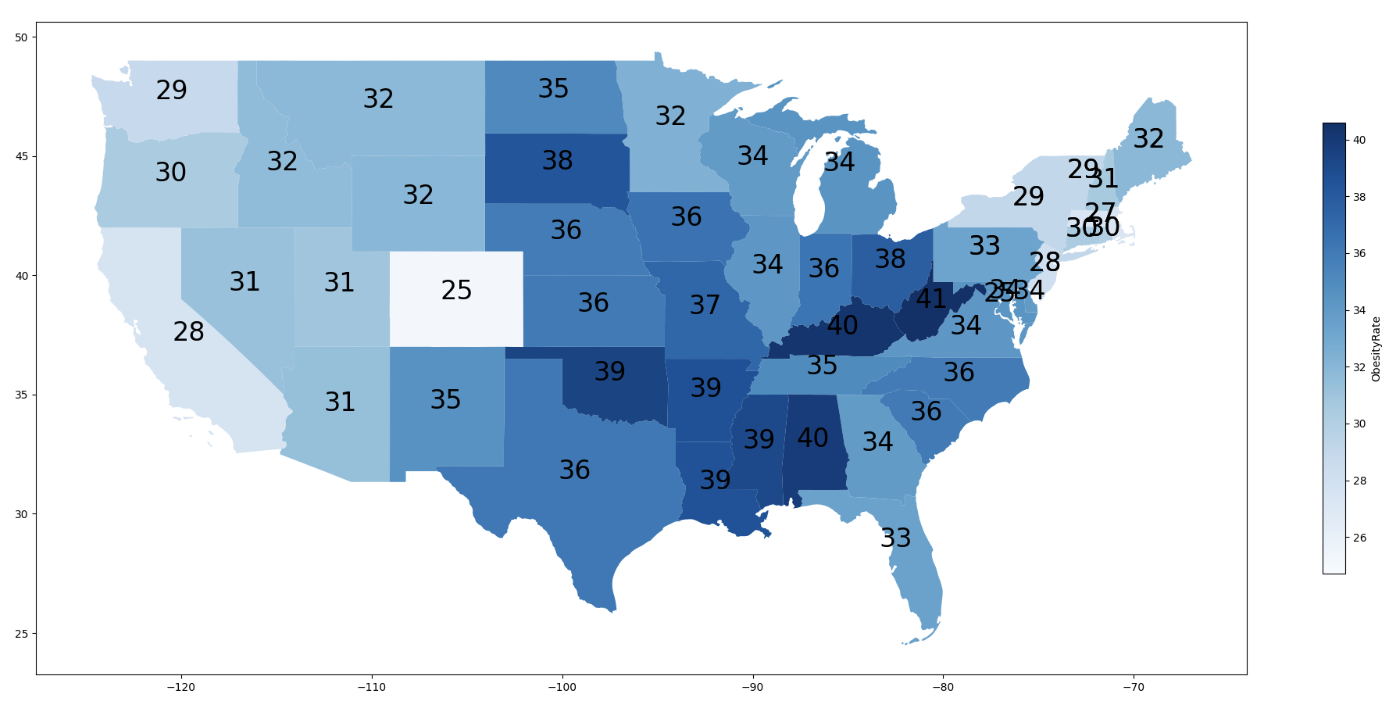

## Abstract

This study dives into the factors that cause obesity besides the obvious unhealthy foods and drinks that one may consume. The study looks for correlations between obesity rates and poverty rates, cost of living, real GDP per state, income per state, income per capita (average income per person per state), median age, and literacy rates. We found that literacy rates, median age, real GDP 2021, and income per state had no effect on obesity rates. On the other hand, we found that poverty rates, income per capita, and cost of living variables showed an effect on obesity. We used ANOVA to determine if there were differences in the high, mid, and low poverty  rate states' obesity rates and found that the means were equal.We moved on to linear regression which gave some insight on the relationship between the variables and obesity rates. The models produced showed a lot of error, but using normalizing and better initial values, we were able to build better linear models. We built multi linear regression models with an R-score of 0.77. We attempted to better that model with Lasso Regression, however, the Lasso method had an R-score of 0.58. Finally, we used power regression to test a nonlinear regression model. The findings in this study show that in low income, low cost of living, and high poverty states, there is higher obesity than in high inome, high cost of living, and low poverty states.

## Introduction

This study attempts to understand what variables effect obesity rates in the United States. We use the US 50 States plus The District of Columbia as (51) observations and have 14 variables. These variables are related to economic status as opposed to the studying the types of foods and drinks that US citizens may consume as in other studies.  \n

The goals of this study are to:

* **Find variables that correlate with obesity.**
* **Understand the root causes of obesity in the US.**
* **Use statistical and data methods  outputs.**



## Data

### Sources


* **Obesity Rates** - https://www.cdc.gov/obesity/data/prevalence-maps.html
* **Poverty Rates** - https://data.ers.usda.gov/reports.aspx?ID=17826
* **Literacy Rates** - https://worldpopulationreview.com/state-rankings/us-literacy-rates-by-state
* **Median Age** - https://www.statsamerica.org/sip/rank_list.aspx?rank_label=pop46&ct=S18
* **GDP, Income, Income Per Capita** - https://www.bea.gov/news/2023/gross-domestic-product-state-and-personal-income-state-4th-quarter-2022-and-year-2022
* **Cost of Living** - https://worldpopulationreview.com/state-rankings/cost-of-living-index-by-state

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import math
from math import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [3]:
data = pd.read_excel('./data/obesityV.xlsx')

In [4]:
names = [ 'ObesityRate', 'PovertyRate', 'LiteracyRate',
       'MedianAge', 'rGDP2021', 'IncomeMills', 'IncomePerCapita', 'Cost Index',
       'Grocery', 'Housing', 'Utilities', 'Transportation', 'Misc'] # except for states

$$Ax = b$$

To clean the data, we will switch all the values that have no data in them. I have done some excel work before bringing the data into jupyter notebooks. It would be cool if you could run an excel package in jupyter...

I changed any empty cells to zeroes and the observations are only the US States and District of Columbia (51 in total).

In [5]:
#Cleaning the data, turning all the zeros to avgs

for col in names:
    mask = data[col] == 0
    data.loc[mask, col] = data.loc[~mask, col].mean()

In [6]:
states = gpd.read_file('geodata/usa-states-census-2014.shp')

In [7]:
us_data = data.copy() #imported earlier in the data section

In [8]:
#data with shape info for plots
merged = states.merge(us_data, left_on='STUSPS', right_on='LocationAbbr', how='left')

In [9]:
#regions
northeast_states = ['NJ','NY','PA','VT','CT','MA','RI','NH','ME']
midwest_states = ['ND','SD','NE','KS','MN','IN','IA','OH','WI','IL','MI','MO']
west_states = ['WA','OR','CA','MT','ID','WY','UT','CO','AZ','NV','NM']
south_states = ['TX','OK','AR','LA','MS','AL','FL','GA','NC','SC','VA','WV','TN','KY','MD','DE','DC']

us_states = us_data[['LocationAbbr','ObesityRate']]

northeast = us_states[us_states['LocationAbbr'].isin(northeast_states)].reset_index()
midwest = us_states[us_states['LocationAbbr'].isin(midwest_states)].reset_index()
west = us_states[us_states['LocationAbbr'].isin(west_states)].reset_index()
south = us_states[us_states['LocationAbbr'].isin(south_states)].reset_index()
regions = [northeast, midwest, west, south]

anova_data = DataFrame({'northeast': northeast['ObesityRate'],
                        'west': west['ObesityRate'],
                        'midwest': midwest['ObesityRate'],
                        'south': south['ObesityRate']})


In [11]:
us_data.head()

,LocationAbbr,ObesityRate,PovertyRate,LiteracyRate,MedianAge,rGDP2021,IncomeMills,IncomePerCapita,Cost Index,Grocery,Housing,Utilities,Transportation,Misc
0,AL,39.80,14.9,85.2,39.5,209979.0,250829.0,49671.0,87.9,98.2,70.1,100.7,92.7,94.1
1,AK,33.60,9.6,90.8,35.3,50869.0,48219.0,65677.0,127.1,134.5,126.9,154.8,109.9,113.7
2,AZ,31.35,12.8,86.9,38.5,347656.0,403739.0,55574.0,103.2,101.5,107.7,104.8,98.8,99.7
3,AR,38.65,15.2,86.3,38.6,123347.0,153186.0,50588.0,90.9,93.1,79.1,92.3,92.3,97.4
4,CA,27.60,11.5,76.9,37.3,2874731.0,3006184.0,76800.0,142.2,113.7,201.9,124.3,131.7,111.3


In [12]:
mean = us_data['ObesityRate'].mean().round(2)

## Methodology & Functions

We will be using the following methods to analyze the data:

* **Sample Comparing**
* **ANOVA**
* **Analysis of categorical Data**
* **Linear Regression**
* **Resampling Methods**
* **Linear Model Selection and Regularization**
* **Nonlinear Methods**


### Statistical Method Functions

In [13]:
def histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=15,ax=ax, figsize=(7,7))
        ax.set_title(var_name, fontsize=8)
    plt.show()

In [14]:
def scatters(df, target, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(7,7))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.scatter(df[var_name], df[target])
        ax.hist(df[var_name], bins=15)
        ax.set_title(f'{var_name} vs. {target}', fontsize=8)
        ax.set_ylabel(target)
        ax.set_xlabel(var_name)
    plt.show()


In [15]:

def shapiro_wilk(data):
    normal_names = list()
    nonnormal_names = list()
    
    for col in names:
        
        # perform Shapiro-Wilk test
        stat, p = shapiro(data[col])

        # print results
        print('Statistics=%.3f, p=%.3f' % (stat, p))

        # interpret results
        alpha = 0.05
        if p > alpha:
            normal_names.append(col)
        else:
            nonnormal_names.append(col)
            
    print('\n\n At alpha = 0.05:')
    
    print('\n The following fail to reject the null hypothesis and look Gaussian')
    for name in normal_names:
        print(name)
    
    print('\n\n The following reject the null hypothesis and do not look Gaussian')
    for name in nonnormal_names:
        print(name)

In [16]:
def compare2samples(data, target): # Comparing Two Samples
    """
    We will use t-test, not normal, sigma uknown, n+m-2 = 10+10-2 = 18 < 30

    t value from table with df=18 and alpha = 0.05
    """

    t_t = 2.101
    
    null = [] #fail to reject null
    alt = [] #reject null
    
    for col in names:
        
        if col == target:
            continue
        
        sorted_data = data.sort_values(by=col)

        low_10 = sorted_data.head(10) #low val
        high_10 = sorted_data.tail(10) #high val

        low_mean = low_10[target].mean()
        low_std = low_10[target].std()
        n = len(low_10)

        high_mean = high_10[target].mean()
        high_std = high_10[target].std()
        m = len(high_10)

        S = sqrt(((n-1)*low_std**2 + (m-1)*high_std**2)/(n+m-2))

        t_0 = (low_mean - high_mean)/(S*(1/n + 1/m)**(1/2))
        
        print(f"{col} t_value:", t_0, '\n')
        
        if abs(t_0)>t_t:
            alt.append(col)
            #print(f'The lowest {col} states are\n',sorted_data[[col,target]].head(10))
            #print(f'The highest {col} states are\n', sorted_data[[col,target]].tail(10), '\n\n')
        else:
            null.append(col)
    print(f"\n\nTable t_val: {t_t} \n\n", 'If the absolute value of the critical t value is greater than t_table, then we reject the null hypothesis.' )    
    print('The following reject the null hypothesis and have unequal obesity rate means at their most polar states:')
    for name in alt:
        print(name)
    print('\n\n The following fail to reject the null hypothesis and have no effect on obesity rates.')
    for name in null:
        print(name)
        
    return alt

In [17]:
def ANOVA(data, variable, target): # Analysis of Variance
    
    data = data[[target, variable]]
    
    _data = data.sort_values(by=variable) #sorted by variable low-high
    
    I = 3 #low, med, high
    J = 17 #51/3
    
    #initialization
    SSB = 0
    SSW = 0 
    
    
    low = _data.loc[[i for i in range(0,17)],:].reset_index()
    med = _data.loc[[i for i in range(17,34)],:].reset_index()
    high = _data.loc[[i for i in range(34,51)],:].reset_index()

    
    anova_data = DataFrame({'low': low[target],
                  'med': med[target],
                  'high': high[target]})
    
    mean = data[target].mean()

    for col in anova_data:
        SSB = SSB + (anova_data[col].mean()-mean)**2
        
    SSB = J*SSB
    
    for col in anova_data:
        column = anova_data[col]
        for var in column:
            SSW = SSW + (var-column.mean())**2

    f = (SSB/(I-1))/(SSW/(I*(J-1)))
    
    return anova_data, f


In [18]:
def ANOCD(regions, target): # Analysis of Categorical Data
    data = np.zeros((5,3))
    for i in range(len(regions)):
        high_counter = 0
        low_counter = 0
        for state in regions[i][target]:
            
            if state >= mean: # global 'ObesityRate' mean
                high_counter += 1
            else:
                low_counter += 1
        data[i][0] = high_counter
        data[i][1] = low_counter
     
    col_sums = []
    col_sum1 = 0
    col_sum2 = 0
    for i in data: 
        col_sum1 += i[0] 
        col_sum2 += i[1]
    data[4][0] = col_sum1
    data[4][1] = col_sum2
    
    row_sums = []
    for i in range(len(data)):
        data[i][2] = data[i].sum()
    
    data[4][2] =  49
    
    chi = 0
    
    for i in range(len(data)):
        for j in range(len(data[0])):
            o = data[i][j] #observation o_i,j
            e = (data[4][j]*data[i][2])/data[4][2] #colsum*rowsum/totsum
            chi += (o-e)**2/e
    
    return anova_data, data, chi

In [19]:
def regression(data_, col, target): # Linear Regression
    
    max_col = data_[col].max()
    max_targ = data_[target].max()

    data = pd.DataFrame()
    data[col] = data_[col] / max_col
    data[target] = data_[target] / max_targ


    expected_o = data[target].mean()
    expected_p = data[col].mean()

    var_o = data[target].var(ddof=1)
    var_p = data[col].var(ddof=1)

    cov_op = data[[target, col]].cov().iloc[0, 1]

    corr_op = cov_op / (sqrt(var_o) * sqrt(var_p))
        
    print(f'{col} and {target} Correlation Coefficient: {corr_op.round(2)} \n')
        
    med_ = data.median(numeric_only=True)

    colRate = data[col]
    beta0 = med_[target]-med_[col]*corr_op
    beta1 = corr_op
    targetRate = beta0 + beta1*colRate
    print("beta_0 (intercept):", beta0.round(2))
    print("beta_1 (slope):", beta1.round(2))
    print(f'\nLinear Regression Line: \n\n {target} = {beta0.round(2)} + {beta1.round(2)}*{col}')

    plt.scatter(data[col], data[target])

    plt.plot(colRate, targetRate, color='red')

    plt.title(f'{col} vs. {target} and Regression')
    plt.ylabel(f'{target}')
    plt.xlabel(f'{col}')
    plt.show()
    
    return corr_op 

    #plt.plot(povertyRate, obesityRate, color='red')

In [20]:
def multilinreg(data, target, variables): #also works for one veriable

    X = data[variables]
    y = data[target]

    X = sm.add_constant(X) 

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(model.summary())



In [21]:
def lasso(data, target, variables):
    #split train test
    X = data[variables]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #lasso 
    lasso = Lasso(alpha=0.05)
    lasso.fit(X_train, y_train)

    # Evaluate model performance on test set
    y_pred = lasso.predict(X_test)

    # Model Score
    print("Model Score: ", lasso.score(X_test, y_test))

    # Lasso Coefficient
    print(lasso.coef_)

In [22]:
def power_regr(x, a, b):
    return a * np.power(x, b)

def power_regr_jac(x, a, b):
    return np.array([np.power(x, b), a * np.power(x, b) * np.log(x)]).T

def nonlinreg(data, target, variable):
    X = data[variable]
    Y = data[target]
    ## plot
    plt.xlabel(variable)
    plt.ylabel(target)
    plt.title('{} vs {}'.format(variable, target))

    colors = ['b', 'g', 'r', 'c', 'm']  # define colors for each line

    num_samples = 3
    sample_size = int(len(data) / num_samples)  # sample size for each line

    for i in range(num_samples):
        ## randomly sample data
        sample = data.sample(n=sample_size, replace=True)
        x_sample = sample[variable]
        y_sample = sample[target]

        ## fit
        res, pcov = curve_fit(
            f=power_regr,
            jac=power_regr_jac,
            xdata=x_sample,
            ydata=y_sample,
            p0=[200, 2],  # it starts at 0, power guess is 2 (quadratic behavior)
        )
        a, b = res

        ## plot data
        plt.scatter(X, Y)

        ## plot curve
        x_curve = np.linspace(min(x_sample), max(x_sample), 100)
        y_curve = power_regr(x_curve, a, b)
        plt.plot(x_curve, y_curve, colors[i], label='Sample {}'.format(i+1))

    plt.legend()
    plt.show()

In [23]:

 def states_graphic():
        
    names = [ 'ObesityRate', 'PovertyRate', 'LiteracyRate',
           'MedianAge', 'rGDP2021', 'IncomeMills', 'IncomePerCapita', 'Cost Index',
           'Grocery', 'Housing', 'Utilities', 'Transportation', 'Misc']

    # interactive dropdown
    dropdown = widgets.Dropdown(
        options=names,
        value='ObesityRate',
        description='Select Parameter:',
    )

    # output
    output = widgets.Output()

    # onChange Function
    def on_dropdown_change(change):
        with output:

            output.clear_output(wait=True)

            fig = plt.figure(1, figsize=(25,15)) 
            ax = fig.add_subplot()

            merged.apply(lambda x: ax.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=12),axis=1);

            col = change.new
            merged.plot(column=col, ax=ax, figsize=(12,12), cmap='Blues', legend_kwds={'label': col, 'shrink': 0.7}, legend=True)

    # dropdown -> function
    dropdown.observe(on_dropdown_change, names='value')

    display(dropdown)
    display(output)


## Analysis and Results

We will begin by trying to learn about the data by plotting histograms of each variable and scatter plots of each vs. obesity rates.

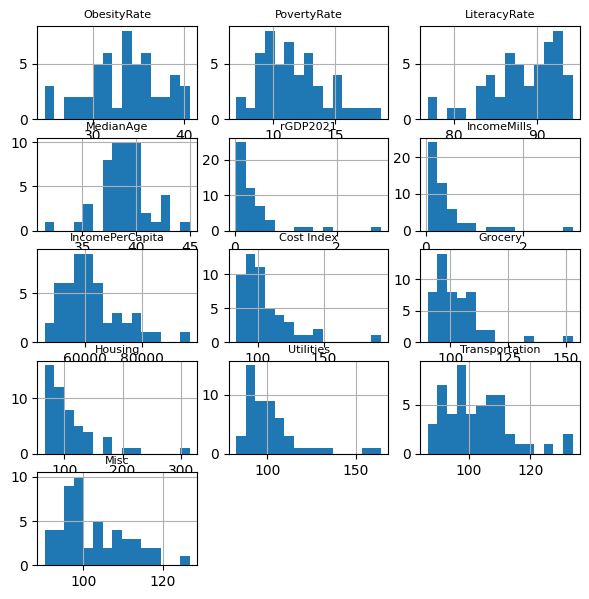

In [24]:
histograms(us_data, names, 5,3)

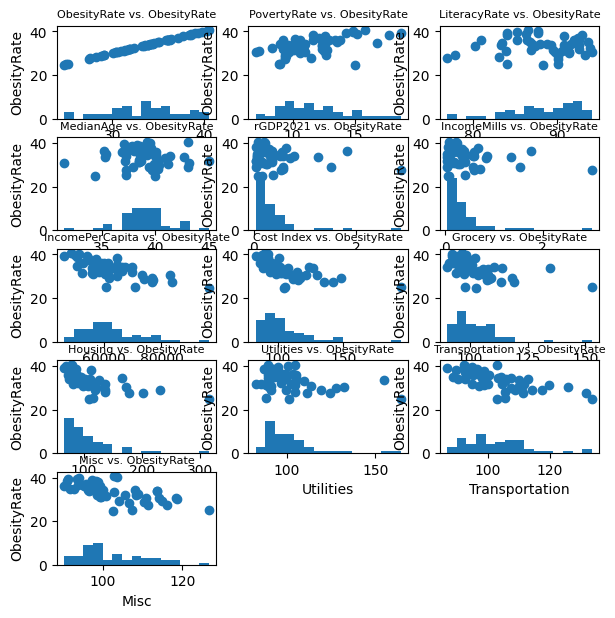

In [25]:
scatters(us_data, 'ObesityRate', names, 5,3)

#### Various Data Visualization Outputs

In [26]:
#geopandas function 'geometry' shape column
merged.explore()

Dropdown(description='Select Parameter:', options=('ObesityRate', 'PovertyRate', 'LiteracyRate', 'MedianAge', …

Output()

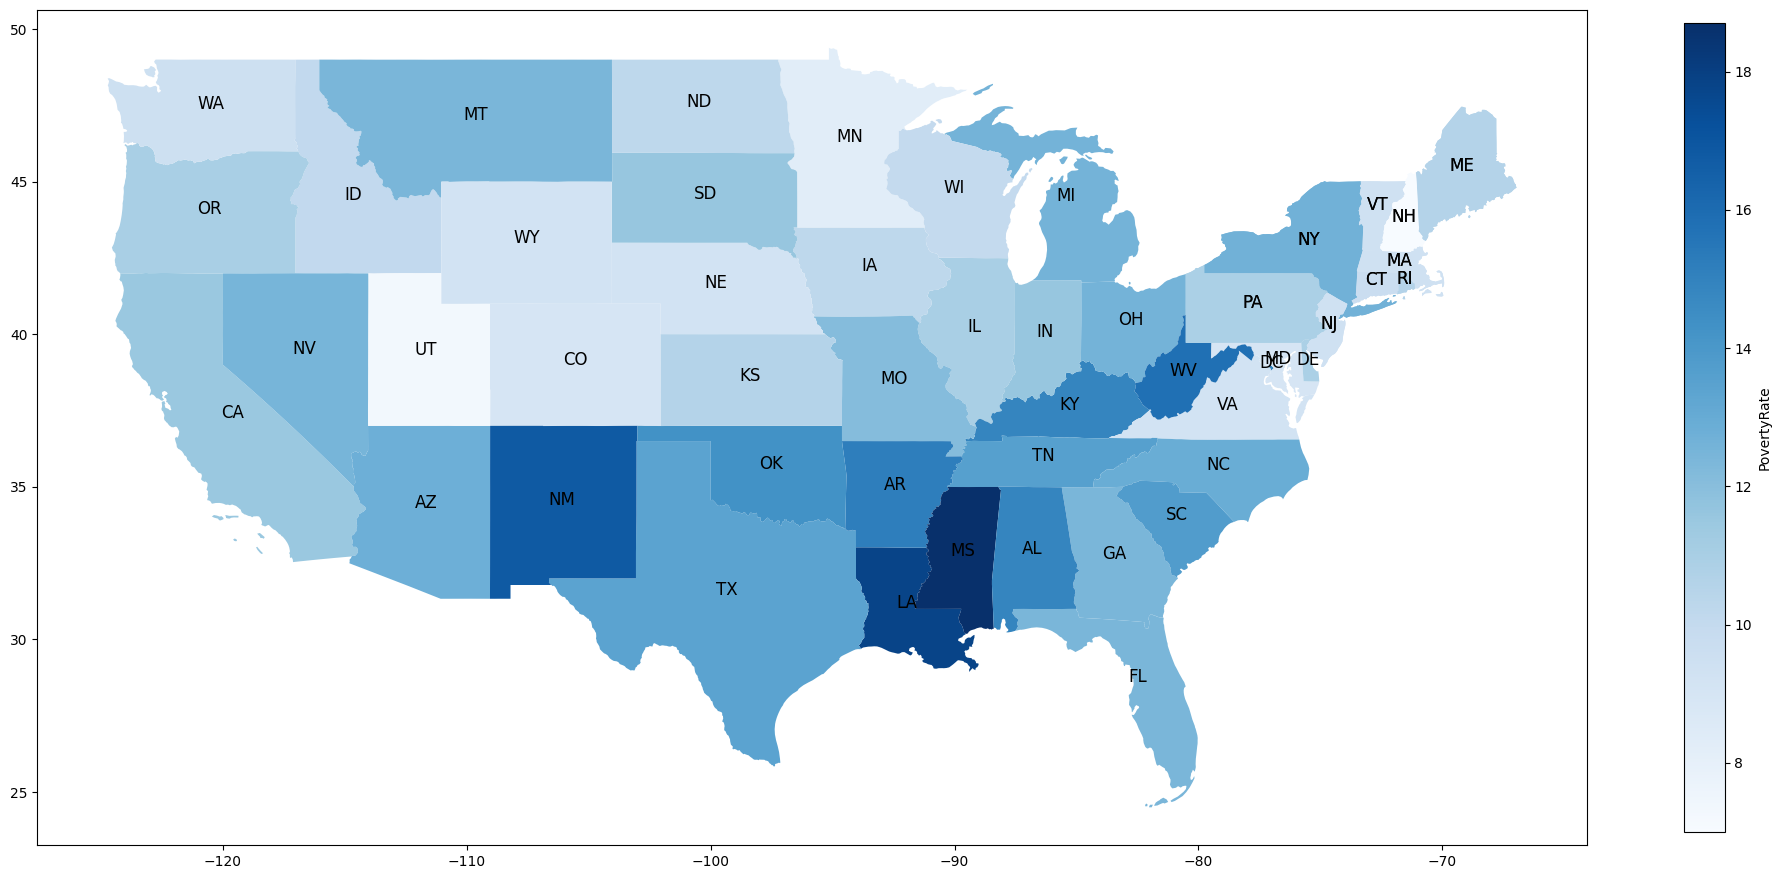

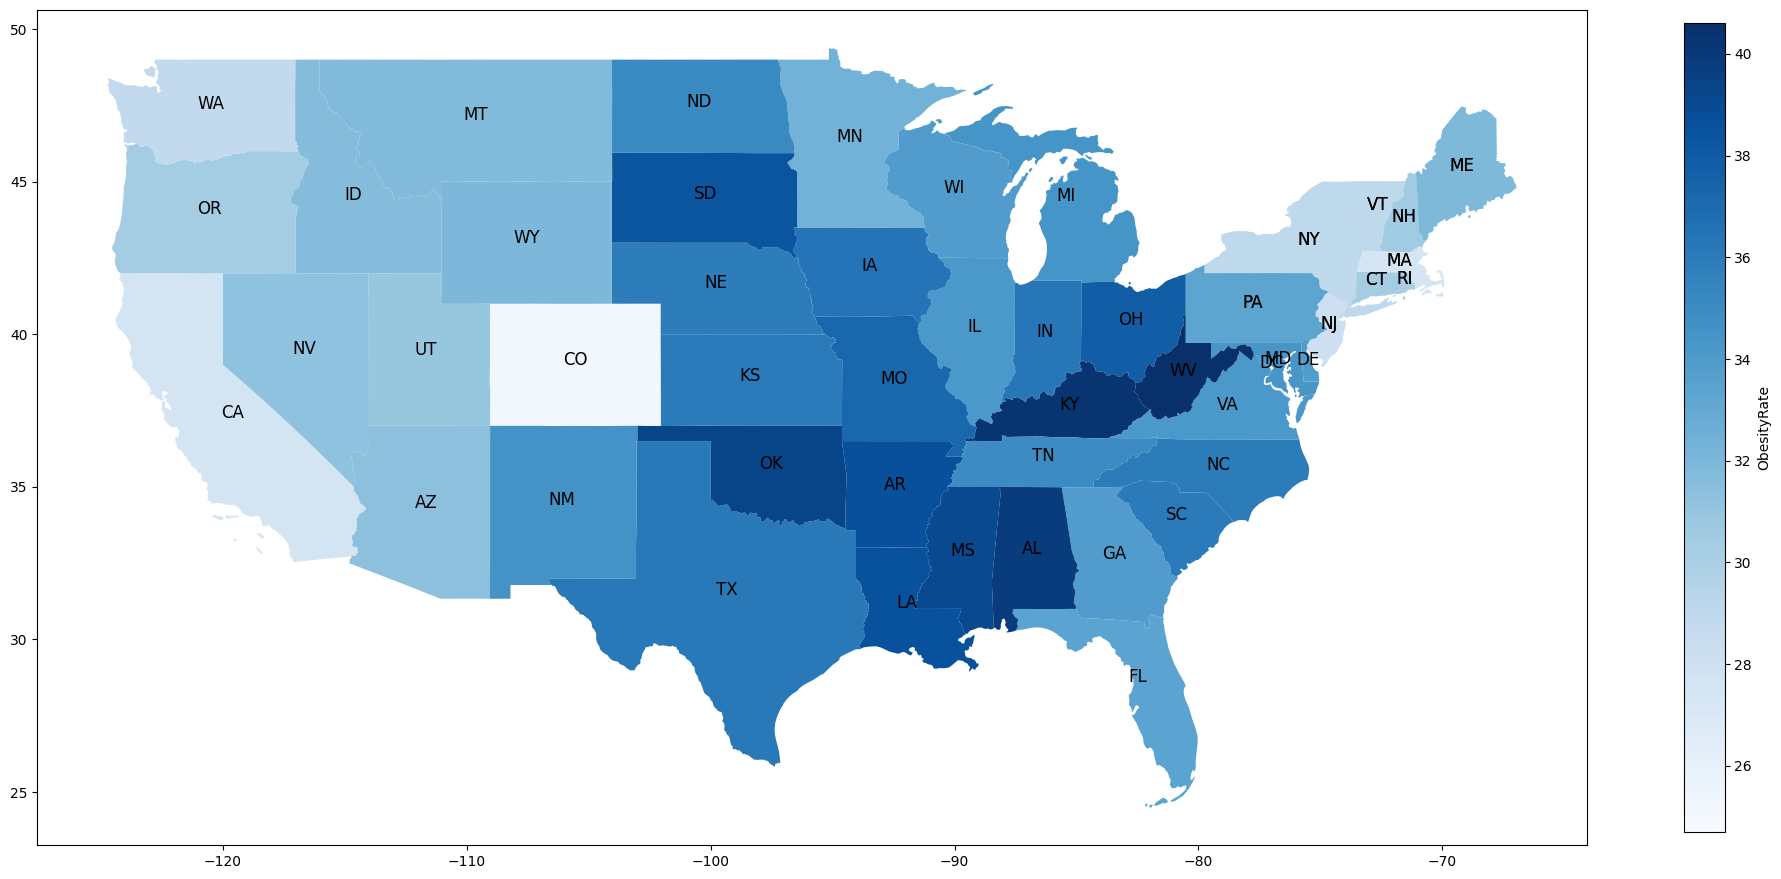

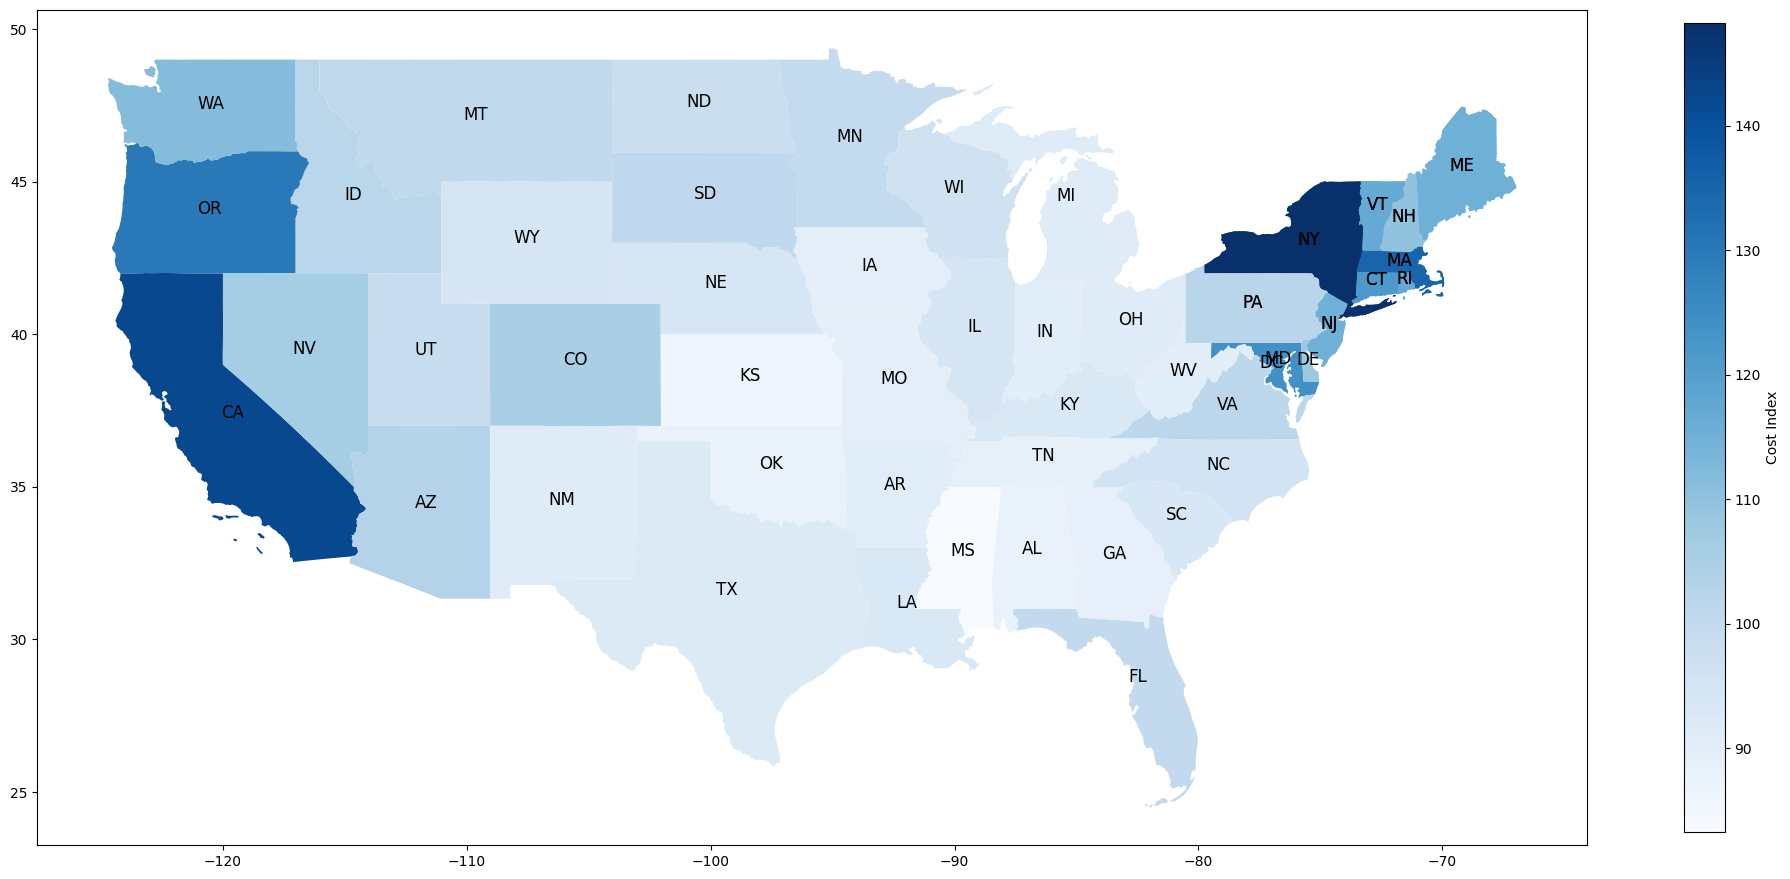

In [27]:
states_graphic()

### Normal Testing

    We will use the Shapiro Wilk Test to test if the US State data is normal for each variable.
$H_0$: Data is normal \
$H_1$: Data is not normal

If the p-values calculated in the test are less than alpha at 0.05, the data is normal.

In [29]:
shapiro_wilk(us_data)

Statistics=0.977, p=0.437
Statistics=0.958, p=0.068
Statistics=0.938, p=0.010
Statistics=0.960, p=0.083
Statistics=0.634, p=0.000
Statistics=0.659, p=0.000
Statistics=0.924, p=0.003
Statistics=0.780, p=0.000
Statistics=0.789, p=0.000
Statistics=0.740, p=0.000
Statistics=0.773, p=0.000
Statistics=0.926, p=0.004
Statistics=0.936, p=0.009


 At alpha = 0.05:

 The following fail to reject the null hypothesis and look Gaussian
ObesityRate
PovertyRate
MedianAge


 The following reject the null hypothesis and do not look Gaussian
LiteracyRate
rGDP2021
IncomeMills
IncomePerCapita
Cost Index
Grocery
Housing
Utilities
Transportation
Misc


### Two Sample Testing

$H_0: \mu_{obesity-low-poverty}=\mu_{obesity-high-poverty}$

$H_1: \mu_{obesity-low-poverty}\neq \mu_{obesity-high-poverty}$

Our population variance is uknown and we have less than thirty samples so we use t-test.

We are using the top ten highest and top ten lowest for each variable. 

$t_0<|t_{n+m-2}(\alpha)|$

We are testing if poverty rate has an effect on obesity rates in the US states. If it does have an effect, we are seeing if low poverty rates correlate with low obesity rates.

In [31]:
alt = compare2samples(us_data, 'ObesityRate')
# returns a list of variables that reject the null hypothesis
# will be used later for linear regression

PovertyRate t_value: -3.29096319168359 

LiteracyRate t_value: -0.5503598029843615 

MedianAge t_value: 0.42376698976585647 

rGDP2021 t_value: 0.8714859480199786 

IncomeMills t_value: -0.5677424225968434 

IncomePerCapita t_value: 7.250831715855436 

Cost Index t_value: 6.7593890460813615 

Grocery t_value: 4.805437589048698 

Housing t_value: 7.9979491721297515 

Utilities t_value: 1.8813033482805892 

Transportation t_value: 7.015569998133264 

Misc t_value: 7.076819126719891 



Table t_val: 2.101 

 If the absolute value of the critical t value is greater than t_table, then we reject the null hypothesis.
The following reject the null hypothesis and have unequal obesity rate means at their most polar states:
PovertyRate
IncomePerCapita
Cost Index
Grocery
Housing
Transportation
Misc


 The following fail to reject the null hypothesis and have no effect on obesity rates.
LiteracyRate
MedianAge
rGDP2021
IncomeMills
Utilities


### Analysis of Variance

$H_0: \mu_{obesity-low-poverty}=\mu_{obesity-medium-poverty}=\mu_{obesity-high-poverty}$

$H_1: \mu_{obesity-i-poverty}\neq \mu_{obesity-j-poverty}$

That is to say, the null hypothesis all means are equal and the alternative is that at least two are not equal.

    We will use F-test because the data is normal and parametric.

In [33]:
f_t = 3.6337 #f_(2,16)(0.05)
anova_data, f = ANOVA(us_data, 'PovertyRate', 'ObesityRate')

if f>f_t:
    print(f'Our critical f value {f} is greater than {f_t},we reject the null hypothesis and the means are not all equal')
else:
    print(f'Our critical f value {f.round(4)} is less than {f_t},we fail to reject the null hypothesis and the means are all equal')


Our critical f value 0.8005 is less than 3.6337,we fail to reject the null hypothesis and the means are all equal


### Analysis of Categorical Data

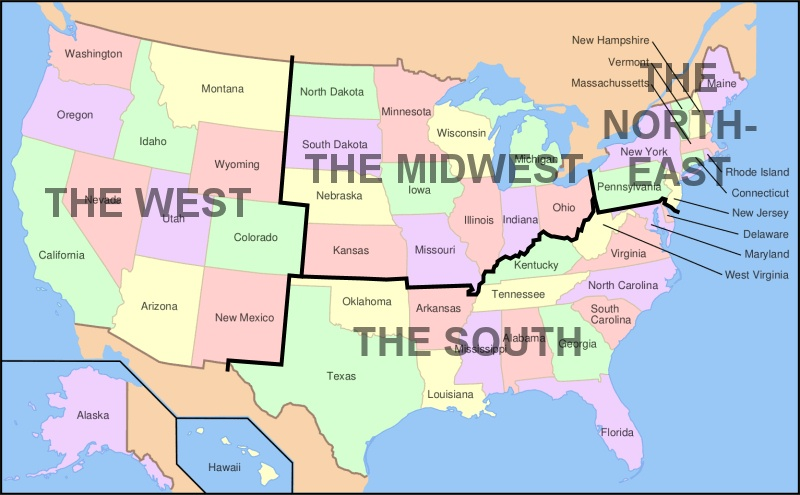

For analysis of categorical we will split the data into categories:
* **Northeast** 
* **Midwest**
* **West**
* **South**

        Note: We are excluding Hawaii and Alaska

We will use a $\chi ^2$ Test for Homogeneity comparing high obesity states and low obesity states.

To segregate high and low obesity, we will treat high as above the mean and low as below the mean. 

In this context, the mean is 33.45 which means that the *low obesity rates* is more like *less high obesity rates*. 

The mean is **33.45%** which means that one third of the US population is obese...

In [34]:
mean

33.45

$H_0: \mu_{obesity-northeast}=\mu_{obesity-west}=\mu_{obesity-midwest}=\mu_{obesity-south}$

$H_1: \mu_{obesity-region_i}\neq \mu_{obesity-region_j}$

That is to say, the null hypothesis all means are equal and the alternative is that at least two are not equal.

In [36]:
chi_t = 11.345 # chi statistic for df of 3 and alpha=0.01
anova_data, data, chi = ANOCD(regions,'ObesityRate')
print('Categorical Data \n', anova_data,'\n\n Chi Squared Matrix \n', data,'\n\n Chi Squared Critical Value: ', chi, '\n Chi Squared Table Value: ', chi_t, '\n\n')
if chi > chi_t:
    print(f'Since our critical value {chi.round(3)} is greater than the critical value from the table, {chi_t}, we reject the null hypothesis and the means of each region, Northeast, Midwest, West, and SOuth are not equal.')
else:
    print(f'Since our critical value {chi.round(3)} is less than the critical value from the table, {chi_t}, we fail to reject the null hypothesis and the means of each region, Northeast, Midwest, West, and SOuth are equal.')

Categorical Data 
        low    med   high
0   39.800  40.35  35.10
1   33.600  38.60  37.75
2   31.350  31.90  39.40
3   38.650  34.35  30.40
4   27.600  27.40  33.30
5   25.150  34.40  30.05
6   30.400  32.35  36.05
7   24.700  39.10  38.35
8   33.900  37.20  34.95
9   33.449  31.80  36.15
10  33.900  35.90  30.95
11  24.950  31.25  29.05
12  31.600  30.60  34.20
13  34.150  28.15  28.80
14  36.300  34.55  40.60
15  36.400  29.10  33.90
16  36.050  36.00  31.95 

 Chi Squared Matrix 
 [[ 0.  9.  9.]
 [11.  1. 12.]
 [ 1. 10. 11.]
 [15.  2. 17.]
 [27. 22. 49.]] 

 Chi Squared Critical Value:  34.48703238565092 
 Chi Squared Table Value:  11.345 


Since our critical value 34.487 is greater than the critical value from the table, 11.345, we reject the null hypothesis and the means of each region, Northeast, Midwest, West, and SOuth are not equal.


In [37]:
print(alt)
print('Since Grocery, Housing, Transportation, and Misc are similar to cost index, we will only plot cost index.')

['PovertyRate', 'IncomePerCapita', 'Cost Index', 'Grocery', 'Housing', 'Transportation', 'Misc']
Since Grocery, Housing, Transportation, and Misc are similar to cost index, we will only plot cost index.


PovertyRate and ObesityRate Correlation Coefficient: 0.54 

beta_0 (intercept): 0.52
beta_1 (slope): 0.54

Linear Regression Line: 

 ObesityRate = 0.52 + 0.54*PovertyRate


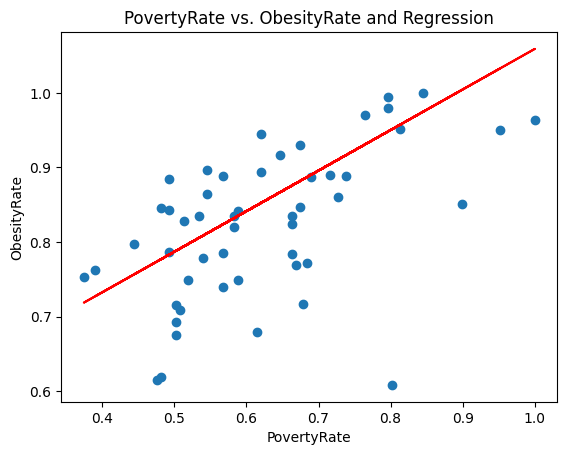

IncomePerCapita and ObesityRate Correlation Coefficient: -0.72 

beta_0 (intercept): 1.28
beta_1 (slope): -0.72

Linear Regression Line: 

 ObesityRate = 1.28 + -0.72*IncomePerCapita


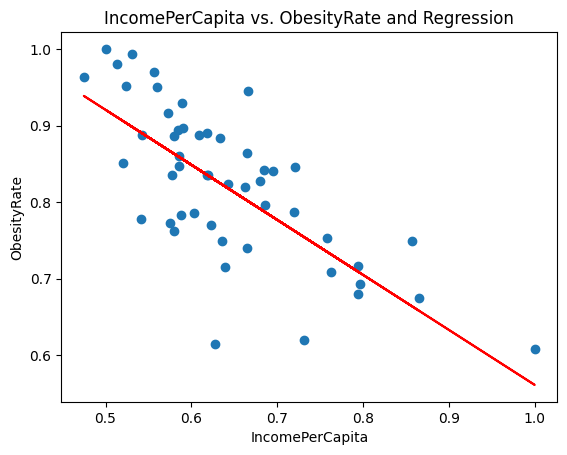

Cost Index and ObesityRate Correlation Coefficient: -0.69 

beta_0 (intercept): 1.19
beta_1 (slope): -0.69

Linear Regression Line: 

 ObesityRate = 1.19 + -0.69*Cost Index


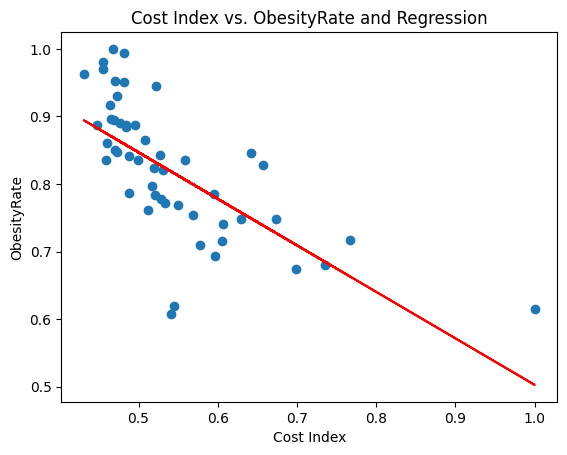

In [38]:
#model variables that showed an effect on obesity in two sample test
cols = ['PovertyRate', 'IncomePerCapita', 'Cost Index']
for col in cols: 
    regression(us_data, col, 'ObesityRate')

### Multiple Linear Regression

We will be using Ordinary Least Squares to build a multi linear regression model of the form

$$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$$

where $\beta_i$ is a weighting correlation coefficient that effects how much the given variable $x_i$ affects $y$.


In [40]:
all_cols = [ 'PovertyRate', 'LiteracyRate',
       'MedianAge', 'rGDP2021', 'IncomeMills', 'IncomePerCapita', 'Cost Index',
       'Grocery', 'Housing', 'Utilities', 'Transportation', 'Misc'] # except for states and obesity

multilinreg(us_data, 'ObesityRate', all_cols)

                            OLS Regression Results                            
Dep. Variable:            ObesityRate   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     10.59
Date:                Fri, 05 May 2023   Prob (F-statistic):           9.42e-09
Time:                        13:11:44   Log-Likelihood:                -105.69
No. Observations:                  51   AIC:                             237.4
Df Residuals:                      38   BIC:                             262.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              20.7498     18.430     

### Bettering the Model

We will use the Lasso Model to try and better our model.

In [41]:
lasso(us_data, 'ObesityRate', all_cols)

Model Score:  0.5870600936118473
[ 0.97328864  0.85910146 -0.          0.          0.18833187 -2.00176485
 -0.          1.27606245 -0.8144701  -0.22180922 -1.22862782 -0.69724787]


### Nonlinear Regression

The nonregularized Obesity vs. Poverty seemed nonlinear and our analysis of variance suggests that Obesity does not increase linearly with Poverty. Here we will try to build a better nonlinear fit using resampling methods.

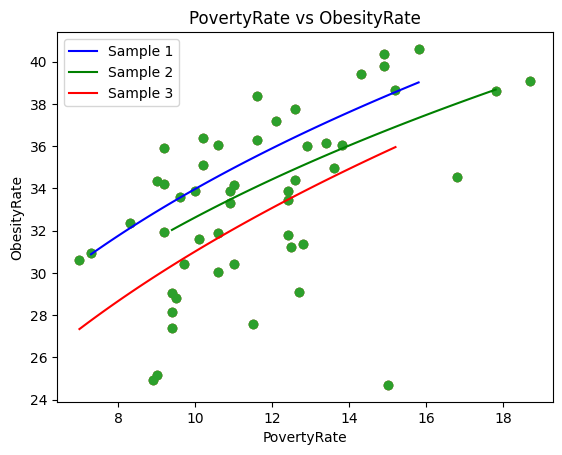

In [43]:
nonlinreg(us_data, 'ObesityRate', 'PovertyRate')

## Conclusion

In conclusion, high poverty, low income, and low cost of living areas of the US correlate with high obesity rates. This is to say that in these areas, unhealthy food is cheap and accessible and healthy food may be expensive and inaccessable. To further this point, future research can be done to study the density of healthy food grocery stores such as Trader Joe's or Whole Foods (even grocery stores) vs. the density of unhealthy food options like fast food chains. Another topic to consider is the quality of the data. The obesity rates were calculated with BMI Index $\frac{weight(kg)}{height(m)^2}$ which has been considered unreliable at times. The Literacy data in this study was also from 2003 as opposed to the rest of the data which was sourced from 2019-2021 so there being no correlation between literacy and obesity may be a faulty finding. In terms of the data analysis, the finding that the high, mid, and low poverty rate state's means were equal in ANOVA testing masy have been due to erroneous sampling and a nonlinear relationship between poverty rates and obesity rates. The linear models built between the variables Poverty Rate, Cost of Living, and Income against obesity showed visually nice fits. In multiple linear regression, standard Least Squares method had an R-score of 0.77 as opposed to Lasso's 0.58. IN the future, we may trey PCA or ridge regression methods to get a better score than 0.77. Finally we tested some nonlinear resampling methods. In the future, we will try to build functions that can resample and retain certain points that generate better goodness of fits.

In [44]:
!jupyter nbconvert --to html US_State_Analysis.ipynb --output /tmp/notebook.html && open /tmp/notebook.html

[NbConvertApp] Converting notebook US_State_Analysis.ipynb to html
[NbConvertApp] Writing 2496056 bytes to /tmp/notebook.html
